# Get started
1. Klicke auf [![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github//IIS-KI-Tutorials/KI-Tutorials/blob/main/automl/1_Bike_Sharing_Regression.ipynb) um eine Session in Colab zu starten.
2. Klicke auf Laufzeit > Laufzeittyp ändern > T4 GPU > Ändern
3. Führe die folgende Zelle aus, um benötigte Requirements zu installieren. Klicke anschließend auf "Restart Session".

In [ ]:
!pip install autogluon

4. Führe die nächste Zelle aus, um die benötigten Daten in die Session zu laden.

In [ ]:
!wget -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/Bike_Sharing_Webinar.csv
!wget -P ./data https://raw.githubusercontent.com/IIS-KI-Tutorials/KI-Tutorials/main/data/CWRU.csv

-------------AB HIER BEGINNEN DIE EIGENTLICHEN TUTORIALS--------------------

# Fahrrad Sharing - Regression mit tabellarischen Daten

Dieses Notebook ist ein einfaches Beispiel dafür, wie man ein Vorhersagemodell mittels AutoML anhand von tabellarischen Daten trainiert.
Ziel ist es, die Nachfrage nach Leihfahrrädern für einen Tag anhand verschiedener Informationen wie Wochentag, Wetterbedingungen etc. vorherzusagen.
Die Zielvariable ist also eine kontinuierliche Größe, weshalb wir in diesem Fall von einem Regressionsproblem sprechen.

## Inhaltsverzeichnis
1. [Importiere AutoML Framework - AutoGluon](#1)<br/>
2. [Laden der Daten](#2)<br/>
3. [Merkmal- und Labelauswahl](#3)<br/>
4. [Unterteile die Daten in Trainings- und Testdaten](#4)<br/>
5. [Modell Training](#5)<br/>
6. [Modell Test](#6)<br/>
7. [Model Interpretation](#7)<br/>
8. [Modell exportieren/speichern](#8)<br/>
9. [Modell laden](#9)<br/>
10. [Vorhersagen für neue Daten](#10)<br/>
11. [Aufgaben](#11)

### 1 Importiere AutoML Framework - AutoGluon <a class="anchor" id="1"></a>
In diesem Beispiel verwenden wir das AutoML-Framework AutoGluon. Da es sich bei dem Datensatz um tabellarische Daten handelt, benötigen wir für die Bearbeitung des vorliegenden Problems  lediglich die Klassen `TabularDataset` und `TabularPredictor`, welche wir hier importieren. Darüber hinaus importieren wir ebenso die Bibliothek `matplotlib` für spätere Visualisierungen.

In [1]:
from autogluon.tabular import TabularDataset, TabularPredictor

import matplotlib.pyplot as plt # Bibliothek für Visualisierungen

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

### 2 Laden der Daten <a class="anchor" id="2"></a>
Als nächstes laden wir die Daten mit Hilfe der `TabularDataset` Klasse und speichern sie in der Variable `data`. Mittels der `head()` Methode können wir uns die ersten 5 Instanzen des Datensatzes anzeigen lassen. Dadurch erhalten wir einen Einblick, wie unsere Daten ausschauen. Allgemeine Informationen zum Datensatz sind unter foldendem Link zu finden: [https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset)

In [2]:
data = TabularDataset('../datasets/Bike_Sharing_Webinar.csv')
data.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,winter,0,1,0,saturday,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,winter,0,1,0,sunday,0,2,NaN,NaN,NaN,NaN,131,670,801
2,2011-01-03,winter,0,1,0,monday,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,winter,0,1,0,tuesday,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,winter,0,1,0,wednesday,1,1,NaN,NaN,NaN,NaN,82,1518,1600


Im Folgenden sehen wir die Auflistung aller Merkmale und Label.
Es sei zu beachten, dass es sowohl kategorische (season und weekday) als auch numerische Merkmale (yr, mnth, ...) gibt.
Teilweise gibt es auch fehlende Messwerte (s. NaN).
Außerdem sei anzumerken, dass es insgesamt drei Label gibt.

Merkmale:
- **dteday**: Datum
- **season**: Jahreszeit
- **yr**: Jahr
    - 0: 2011
    - 1: 2012
- **mnth**: Monat (1 bis 12)
- **holiday**: Feiertag?
    - nein: 0
    - ja: 1
- **weekday**: Wochentag
- **workingday**:
    - 1: wenn weder Wochenende noch Feiertag
    - 0: sonst
- **weathersit**:
    - 1: klar, leicht/teilweise bewölkt
    - 2: bewölkt, Nebel
    - 3: leichter Regen/Schnee, Gewitter
    - 4: starker Regen/Schnee, Sturm
- **temp**: Temperatur (normalisiert)
- **atemp**: gefühlte Temperatur (normalisiert)
- **hum**: Luftfeuchtigkeit
- **windspeed**: Windgeschwindigkeit (normalisiert)

Label:
- **casual**: Anzahl der nicht-registrierten Nutzer
- **registered**: Anzahl der registrierten Nutzer
- **cnt**: Gesamtzahl der Nutzern

### 3 Merkmal- und Labelauswahl <a class="anchor" id="3"></a>
Damit das AutoML Framework später ein Modell trainieren kann, müssen wir zunächst angeben, welche der Spalten Merkmale repräsentieren und welche die Label. Für den Moment wollen wir `casual` als Label wählen, d.h. wir wollen also die Anzahl der nicht-registrierten Nutzer pro Tag vorhersagen. Bei den Merkmalen lassen wir das Datum weg, da wir schon über die Spalten 'yr', 'mnth' sowie 'weekday' verfügen.

In [3]:
features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed']
label = 'casual'

Um ein besseres Verständnis über die Daten zu erlangen, wollen wir nun das ausgewählte Label über die Zeit plotten. Hier wird z.B. deutlich, dass es einen merklichen saisonalen Effekt gibt. Die Nachfrage nach Fahrrädern ist also im Sommer höher als im Winter. Auch gibt es deutliche Schwankungen innerhalb einer Woche. So zeigt sich, dass die Anzahl der nicht-registrierten Nutzer vor allem am Wochende hoch ist, während sie unter der Wocher deutlich geringer ausfällt.

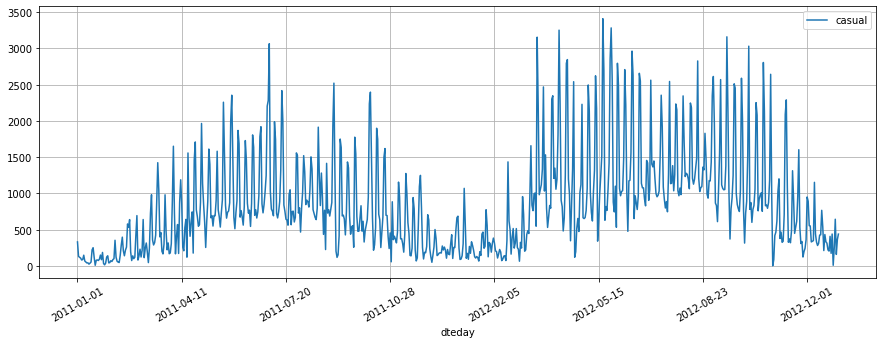

In [4]:
fig, ax = plt.subplots(figsize=(15, 5))
data.plot('dteday', label, rot=30, ax=ax)
plt.grid()

### 4 Unterteile die Daten in Trainings- und Testdaten <a class="anchor" id="4"></a>
Nun unterteilen wir unseren Datensatz in Trainings- und Testset.

Die ersten 80% der Daten werden als Trainingsdaten und die letzten 20% als Testdaten ausgewählt. Das AutoML Framework wird also lediglich die Trainingsdaten für das Training und Validieren von Modellen benutzen. Mit den Testdaten wird das finale Modell abschließend getestet, um seine Genauigkeit angeben zu können.

In [5]:
train_size = round(0.8 * len(data))

all_columns =  features + [label]

data_train = data.loc[:train_size, all_columns]
data_test = data.loc[train_size:, all_columns]

### 5 Modell Training <a class="anchor" id="5"></a>
In der folgenden Zelle findet das Modell Training durch das AutoML Framework statt.

In der ersten Zeile erzeugen wir zuerst eine Instanz der Klasse `TabularPredictor` und speichern diese in der Variablen `predictor`.
Hier müssen wir lediglich den Namen der Zielvariable angeben (Diese haben wir vor einigen Zellen bereits in der Variable `label` gespeichert).
Optional kann man auch den Pfad angeben, in dem sämtliche Modelle gespeichert werden sollen (hier: "AutogluonModels/Fahrrad_Sharing").
Gibt man keinen Pfad an, so wird automatisch ein Ordner "AutogluonModels/ag-\<Datum>_\<Uhrzeit>"  erstellt, in dem die Modelle gespeichert werden.

In der zweiten Zeile rufen wir dann die `fit()` Methode auf, welche das Modell Training startet.
Diese Methode benötigt unsere vorher definierten Trainingsdaten als Argument.

Das AutoML Framework trainiert und validiert nun mit Hilfe dieser Daten viele verschiedene Modelle und gibt automatisch das beste Ensemble-Modell zurück.
Dieses speichern wir in der `predictor` Variable.

Es sei zu beachten, dass das Framework automatisch erkennt, dass es sich um ein Regressionsproblem handelt.
Auch erkennt es die verschiedenen Datentypen der vorhandenen Merkmale und kodiert etwa die kategorischen Label automatisch in numerische um.

In [6]:
predictor = TabularPredictor(label=label, path='AutogluonModels/Fahrrad_Sharing')
predictor.fit(data_train);

Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels/Fahrrad_Sharing\"
AutoGluon Version:  0.5.2
Python Version:     3.9.12
Operating System:   Windows
Train Data Rows:    586
Train Data Columns: 11
Label Column: casual
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (3410, 9, 811.36689, 676.6872)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    5825.05 MB
	Train Data (Original)  Memory Usage: 0.12 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify 

Mit der `fit_summary()` Methode können wir uns eine Zusammenfassung und Übersicht der trainierten Modelle anzeigen lassen. Die zweite Spalte zeigt hier den jeweiligen "score_val", sprich den RMSE (Wurzel des mittleren quadratischen Fehlers) auf den Validierungsdaten. Nach diesem Wert sind auch die Modelle absteigend sortiert. Das gewichtete Ensemble hat also die besten Ergebnisse erzielt.

Es wird darüber hinaus ein Diagramm erstellt, welches unter dem Pfad "AutogluonModels/Fahrrad_Sharing/SummaryOfModels.html" zu finden ist.

In [7]:
summary = predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                  model   score_val  pred_time_val   fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0   WeightedEnsemble_L2 -212.910530       0.062016  30.398674                0.000000           0.571019            2       True         12
1            LightGBMXT -218.646536       0.006004   1.844259                0.006004           1.844259            1       True          3
2              CatBoost -223.832761       0.012008  20.095408                0.012008          20.095408            1       True          6
3              LightGBM -234.448532       0.007004   0.394001                0.007004           0.394001            1       True          4
4               XGBoost -243.646787       0.012999   1.685387                0.012999           1.685387            1       True          9
5         ExtraTreesMSE -244.419023       0.119004   0.595591                0.119004           0.

### 6 Modell Test <a class="anchor" id="6"></a>
Zum Testen und Evaluieren des finalen Modells verwenden wir die vorab separierten Testdaten.

Zunächst benutzen wir die `predict()` Methode, um unsere Vorhersagen für den Testdatensatz zu machen. Die Vorhersagen speichern wir in der `predictions` Variable.

Außerdem nutzen wir die `evaluate()` Methode, um eine Reihe von Qualitätsmaßen zu berechnen (wie etwa RMSE, MSE etc.). 

In [8]:
predictions = predictor.predict(data_test)
pred_metrics = predictor.evaluate(data_test)

Evaluation: root_mean_squared_error on test data: -263.6526756498307
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -263.6526756498307,
    "mean_squared_error": -69512.73337731483,
    "mean_absolute_error": -182.40001690224426,
    "r2": 0.8597284736250072,
    "pearsonr": 0.9272803884899582,
    "median_absolute_error": -119.67518615722656
}


Hier sehen wir abermals eine Überischt aller trainierten Modelle. Die Tabelle beinhaltet jetzt auch die Spalte "score_test". Diese zeigt den jeweiligen RMSE auf den Testdaten.

In [9]:
predictor.leaderboard(data_test, silent=True)

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L2,-263.652676,-212.910530,0.152997,0.062016,30.398674,0.015999,0.000000,0.571019,2,True,12
1,CatBoost,-277.101407,-223.832761,0.008999,0.012008,20.095408,0.008999,0.012008,20.095408,1,True,6
2,LightGBMXT,-279.669992,-218.646536,0.021999,0.006004,1.844259,0.021999,0.006004,1.844259,1,True,3
3,LightGBM,-295.540703,-234.448532,0.016999,0.007004,0.394001,0.016999,0.007004,0.394001,1,True,4
4,NeuralNetTorch,-295.741319,-293.297027,0.050003,0.024001,5.808600,0.050003,0.024001,5.808600,1,True,10
5,RandomForestMSE,-311.101361,-250.066254,0.225657,0.056379,0.778896,0.225657,0.056379,0.778896,1,True,5
6,ExtraTreesMSE,-311.207706,-244.419023,0.167003,0.119004,0.595591,0.167003,0.119004,0.595591,1,True,7
7,LightGBMLarge,-314.317332,-256.675190,0.023001,0.010001,1.049668,0.023001,0.010001,1.049668,1,True,11
8,XGBoost,-327.450622,-243.646787,0.038998,0.012999,1.685387,0.038998,0.012999,1.685387,1,True,9
9,NeuralNetFastAI,-377.800826,-309.892033,0.045002,0.046003,4.224016,0.045002,0.046003,4.224016,1,True,8


Nun wollen wir die Ergebnisse visualisieren. In folgendem Plot sieht man sowohl die tatsächliche Nachfrage als auch unsere vom Modell vorhergesagte Nachfrage über die Zeit.

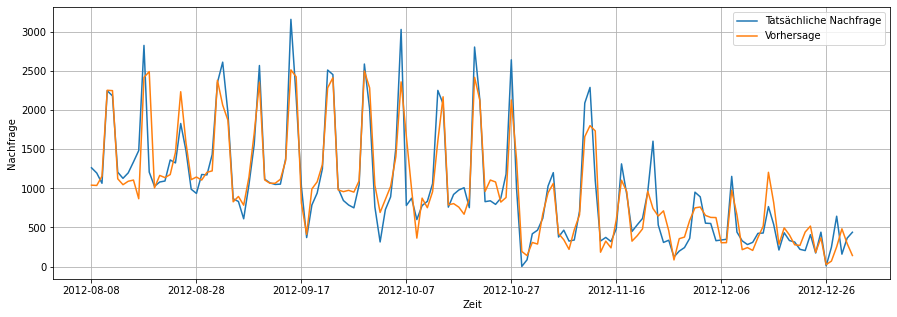

In [10]:
data_test[f'{label}_prediction'] = predictions
data_test['dteday'] = data.loc[train_size:, 'dteday']

fig, ax = plt.subplots(figsize=(15, 5))
data_test.plot(x="dteday", y=[f"{label}", f"{label}_prediction"], xlabel="Zeit", ylabel="Nachfrage", style='-', ax=ax)
plt.grid()
ax.legend(["Tatsächliche Nachfrage", "Vorhersage"]);

### 7 Model Interpretation <a class="anchor" id="7"></a>
In der folgenden Zelle wird die sog. Merkmalswichtigkeit (engl.: feature importance) berechnet und aufgelistet. Je höher die Wichtigkeit (importance), desto einflussreicher ist das jeweilige Merkmal bei der Bestimmung einer Vorhersage. Dies kann sehr aufschlussreich sein und trägt zum besseren Verständnis der Daten bei.

In [11]:
predictor.feature_importance(data_test, silent=True)

These features in provided data are not utilized by the predictor and will be ignored: ['casual_prediction', 'dteday']


,importance,stddev,p_value,n,p99_high,p99_low
workingday,382.163089,38.026814,0.000012,5,460.460825,303.865353
atemp,165.672754,11.539724,0.000003,5,189.433206,141.912302
temp,123.766290,17.652857,0.000048,5,160.113766,87.418814
weekday,56.122823,3.629811,0.000002,5,63.596653,48.648992
hum,53.919458,11.996290,0.000276,5,78.619984,29.218932
windspeed,49.950801,11.929401,0.000362,5,74.513602,25.388000
weathersit,24.876758,6.085258,0.000397,5,37.406388,12.347128
mnth,12.268432,3.001202,0.000397,5,18.447949,6.088916
season,4.387990,2.228876,0.005836,5,8.977277,-0.201296
holiday,0.409046,0.168853,0.002814,5,0.756716,0.061376


### 8 Modell exportieren/speichern <a class="anchor" id="8"></a>
Um das trainierte Modell später wieder laden und benutzen zu können, muss es gespeichert werden. Dies geschieht schon automatisch beim Modell Training. Bei Bedarf kann man jedoch auch im Nachhinhein das Modell mittels der `save()` Methode speichern.

In [12]:
predictor.save()

TabularPredictor saved. To load, use: predictor = TabularPredictor.load("AutogluonModels/Fahrrad_Sharing\")


### 9 Modell laden <a class="anchor" id="9"></a>
Um ein gespeichertes Modell zu laden, ruft man ganz einfach die `load()` Methode auf.

In [13]:
predictor = TabularPredictor.load(path="./AutogluonModels/Fahrrad_Sharing")

### 10 Vorhersagen für neue Daten <a class="anchor" id="10"></a>
Das geladene Modell kann nun genutzt werden, um Vorhersagen auf zukünftigen, komplett unbekannten Daten zu machen. Da wir über solche nicht verfügen, laden wir hier eine zufällige Instanz aus dem uns vorliegenden Datensatz und machen dafür eine Vorhersage mit unserem geladenen Modell.

In [14]:
test_day = data.sample() # eine zufällige Instanz wird aus dem Datensatz gezogen
test_day

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
628,2012-09-20,summer,1,9,0,thursday,1,1,0.546667,0.532192,0.618333,0.118167,939,6781,7720


In [15]:
prediction = predictor.predict(test_day)
print(f'Vorhergesagte Nachfrage ({label}): {round(prediction.values[0])} Fahrräder')

Vorhergesagte Nachfrage (casual): 1083 Fahrräder


### 11 Aufgaben <a class="anchor" id="11"></a>

1. Ändern Sie den Code unter [3 Merkmal- und Labelauswahl](#3), sodass anstatt "casual" ein anderes Label zum Training eines Modells herangezogen wird. Achten Sie insbesondere auch darauf, dass alle zur Vorhersage verwendeten Merkmale sinnvoll gewählt sind. Wie verändert sich die Vorhersagegenauigkeit verglichen zu dem zuvor gewähltem Label "casual"?
2. Außer den Trainingsdaten und der Angabe des Labels benötigt AutoGluon keinen weiteren Input zum Trainieren eines Modells. Es ist jedoch möglich weitere Parameter anzupassen, um den Trainingsprozess zu beeinflussen. Eine sehr praktische Möglichkeit dafür ist der Parameter `presets` der `fit()`-Methode . Informieren Sie sich zunächst dazu in der [Dokumentation von AutoGluon](https://auto.gluon.ai/stable/api/autogluon.predictor.html#autogluon.tabular.TabularPredictor.fit) und probieren sie anschließend verschiedene `presets` aus. Passen Sie dazu den Code unter [5 Modell Training](#3) entsprechend an. Welche Veränderungen beim Trainingsprozess und bei den resultierenden Modellen können Sie feststellen?
3. Überlegen Sie sich, welche Merkmale geeignet sein könnten um die Nachfrage eines Produkts/einer Dienstleistung Ihres Unternehmens vorherzusagen? Welcher Aufwand wäre mit der Erhebung der Daten erforderlich?